In [77]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from pyquaternion import Quaternion

In [78]:
Tmax = 0.000953
Wmax = 1570.79632679
Vmax = 6
a_1 = np.array([[1],[0],[0]])
a_2 = np.array([[0],[1],[0]])
a_3 = np.array([[0],[0],[1]])
a_mat = np.concatenate((a_1, a_2, a_3), axis=1)
I = np.array([[0.04, 0.00, 0.00],
              [0.00, 0.05, 0.02],
              [0.00, 0.02, 0.05]])
I_inv = np.linalg.inv(I)
I_rw = 6.25E-05
I_wheels = I_rw*(a_1*np.transpose(a_1) + a_2*np.transpose(a_2) + a_3*np.transpose(a_3))

In [79]:
def dynamics(x, u):
    q = x[0:4, :]
    w = x[4:7, :]
    Omega = x[7:10, :]
    V = u
    return ca.vertcat(
        -w[0]*q[1]-w[1]*q[2]-w[2]*q[3], # Quaternion dynamics
        w[0]*q[0] +w[1]*q[3]-w[2]*q[2],
        -w[0]*q[3]+w[1]*q[0]+w[2]*q[1],
        w[0]*q[2] -w[1]*q[1]+w[2]*q[0],
        -(Tmax/Vmax)*a_mat@V + (Tmax/Wmax)*a_mat@Omega - ca.cross(w, (I@w) + (I_wheels@w) + I_rw*(a_mat@Omega)),
        (Tmax/(Vmax*I_rw))*V - (Tmax/(Wmax*I_rw))*Omega - a_mat.T@w # RW Velocities
    )

In [80]:
N = 200  # Number of control intervals
opti = ca.Opti()

# State variables
X = opti.variable(4 + 3 + 3, N + 1)
q = X[0:4, :]
w = X[4:7, :]
Omega = X[7:10, :]

# Control variables
U = opti.variable(3, N) # 3 inputs

# Total time variable
T = opti.variable()
dt = T / N  # length of one control interval

# Minimize time
opti.minimize(T)

# Apply dynamic constriants
for k in range(N):
    x_next = X[:, k] + dynamics(X[:, k], U[:, k]) * dt
    opti.subject_to(X[:, k + 1] == x_next)

# Apply input constraints
opti.subject_to(
    opti.bounded(np.full(U.shape, -6), U, np.full(U.shape, 6)) # May need to make it multivariate
)

# Other constraints
for k in range(N + 1):
    opti.subject_to(q[0, k]**2 + q[1, k]**2 + q[2, k]**2 + q[3, k]**2 == 1)

# Boundary conditions
# Start
opti.subject_to(q[0, 0] == 1)
opti.subject_to(q[1, 0] == 0)
opti.subject_to(q[2, 0] == 0)
opti.subject_to(q[3, 0] == 0)
opti.subject_to(w[0, 0] == 0)
opti.subject_to(w[1, 0] == 0)
opti.subject_to(w[2, 0] == 0)
opti.subject_to(Omega[0, 0] == 0)
opti.subject_to(Omega[1, 0] == 0)
opti.subject_to(Omega[2, 0] == 0)
opti.subject_to(U[0, 0] == 0)
opti.subject_to(U[1, 0] == 0)
opti.subject_to(U[2, 0] == 0)

# End
# opti.subject_to(q[0, -1] == -0.0434363)
# opti.subject_to(q[1, -1] == -0.5855824)
# opti.subject_to(q[2, -1] == -0.7539713)
# opti.subject_to(q[3, -1] == -0.2945059)
opti.subject_to(ca.norm_2(q[:,-1] - np.array([-0.0434363,-0.5855824,-0.7539713,-0.2945059]))<=1e-5)
opti.subject_to(w[0, -1] == 0)
opti.subject_to(w[1, -1] == 0)
opti.subject_to(w[2, -1] == 0)
opti.subject_to(Omega[0, -1] == 0)
opti.subject_to(Omega[1, -1] == 0)
opti.subject_to(Omega[2, -1] == 0)
opti.subject_to(U[0, -1] == 0)
opti.subject_to(U[1, -1] == 0)
opti.subject_to(U[2, -1] == 0)

# Time constraints
opti.subject_to(T >= 0)
 
# Initial guess
# opti.set_initial(q[0], 1)
# opti.set_initial(q[1], 0)
# opti.set_initial(q[2], 0)
# opti.set_initial(q[3], 0)
# opti.set_initial(w[0], 0)
# opti.set_initial(w[1], 0)
# opti.set_initial(w[2], 0)
# opti.set_initial(Omega[0], 0)
# opti.set_initial(Omega[1], 0)
# opti.set_initial(Omega[2], 0)
# opti.set_initial(U[0], 0)
# opti.set_initial(U[1], 0)
# opti.set_initial(U[2], 0)
# opti.set_initial(T, 10)
opti.set_initial(X, np.zeros(X.shape))
opti.set_initial(U, np.zeros(U.shape))
opti.set_initial(T, 10)

In [105]:
opti.solver("ipopt", {}, {"mu_init": 1e-3, "max_iter": 3000, "acceptable_tol":1e-4})  # set numerical backen

In [106]:
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    18826
Number of nonzeros in inequality constraint Jacobian.:      605
Number of nonzeros in Lagrangian Hessian.............:     8810

Total number of variables............................:     2611
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2223
Total number of inequality constraints...............:      602
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:      600
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+01 1.00e+00 1.00e+00  -3.0 0.00e+00    -  0.00e+00 0.00e+00 

  83  2.0037564e+01 5.39e-01 2.26e+04  -3.0 1.02e+03    -  9.74e-03 2.95e-03h  1
  84  2.0153789e+01 5.37e-01 2.25e+04  -3.0 1.25e+03    -  2.91e-03 3.53e-03h  1
  85  2.0304139e+01 5.34e-01 2.24e+04  -3.0 1.05e+03    -  1.03e-02 4.60e-03h  1
  86  2.0365058e+01 5.33e-01 2.23e+04  -3.0 1.07e+03    -  5.64e-03 1.86e-03h  1
  87  2.0557333e+01 5.30e-01 2.22e+04  -3.0 1.06e+03    -  4.51e-03 5.80e-03h  1
  88  2.0664779e+01 5.28e-01 2.20e+04  -3.0 1.11e+03    -  1.04e-02 3.19e-03h  1
  89  2.0771027e+01 5.27e-01 2.20e+04  -3.0 1.41e+03    -  3.10e-03 3.08e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.0888108e+01 5.25e-01 2.18e+04  -3.0 9.88e+02    -  8.64e-03 3.45e-03h  1
  91  2.0974235e+01 5.24e-01 2.18e+04  -3.0 1.20e+03    -  3.16e-03 2.49e-03h  1
  92  2.1159613e+01 5.21e-01 2.16e+04  -3.0 1.15e+03    -  7.93e-03 5.34e-03h  1
  93  2.1192727e+01 5.20e-01 2.15e+04  -3.0 1.12e+03    -  7.47e-03 9.51e-04h  1
  94  2.1378497e+01 5.18e-01

 185  3.5902575e+01 4.05e-01 9.26e+03  -3.0 1.66e+03    -  4.98e-03 2.63e-03h  1
 186  3.5918276e+01 4.05e-01 8.98e+03  -3.0 1.50e+03    -  5.14e-03 1.32e-04h  1
 187  3.6124988e+01 4.04e-01 8.93e+03  -3.0 1.49e+03    -  2.30e-03 1.67e-03h  2
 188  3.6285247e+01 4.04e-01 8.87e+03  -3.0 1.80e+03    -  1.97e-03 1.17e-03h  3
 189  3.6473993e+01 4.03e-01 8.65e+03  -3.0 1.87e+03    -  4.64e-03 1.34e-03h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  3.6585065e+01 4.03e-01 8.61e+03  -3.0 1.90e+03    -  1.23e-03 7.71e-04h  2
 191  3.6803033e+01 4.02e-01 8.67e+03  -3.0 1.94e+03    -  3.81e-04 1.45e-03h  1
 192  3.6822221e+01 4.02e-01 8.34e+03  -3.0 1.51e+03    -  5.73e-03 1.44e-04h  1
 193  3.7079290e+01 4.02e-01 8.38e+03  -3.0 2.10e+03    -  8.83e-04 1.65e-03h  1
 194  3.7261334e+01 4.01e-01 8.06e+03  -3.0 2.08e+03    -  5.51e-03 1.16e-03h  1
 195  3.7459164e+01 4.01e-01 7.86e+03  -3.0 1.96e+03    -  3.88e-03 1.23e-03h  2
 196  3.7650788e+01 4.00e-01

 278r 5.0015181e+01 1.61e-01 9.73e+02  -2.3 8.33e+02    -  7.92e-03 3.40e-02f  1
 279r 5.3471519e+01 1.98e-01 9.51e+02  -2.3 4.42e+02    -  2.24e-02 2.60e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280r 5.8987048e+01 2.81e-01 8.96e+02  -2.3 3.32e+02    -  5.83e-02 4.70e-02f  1
 281r 7.1697574e+01 9.73e-01 9.76e+02  -2.3 2.67e+02    -  6.67e-02 1.25e-01f  1
 282r 8.3285245e+01 1.16e+00 9.32e+02  -2.3 6.52e+02    -  1.29e-02 5.91e-02f  1
 283r 9.1763549e+01 8.58e-01 1.14e+03  -2.3 7.76e+01  -4.0 9.32e-02 1.89e-01f  1
 284r 9.5704476e+01 8.82e-01 1.15e+03  -2.3 1.94e+03  -4.5 3.68e-03 2.80e-03f  1
 285r 1.0998456e+02 1.03e+00 1.01e+03  -2.3 1.18e+02  -4.1 8.59e-02 1.44e-01f  1
 286r 1.1955983e+02 9.27e-01 1.02e+03  -2.3 5.17e+01  -3.6 1.25e-01 1.85e-01f  1
 287r 1.3337156e+02 6.46e-01 1.29e+03  -2.3 4.91e+01  -3.2 1.40e-01 2.82e-01f  1
 288r 1.3417383e+02 5.67e-01 1.15e+03  -2.3 6.67e+00  -2.8 1.09e-01 1.20e-01h  1
 289r 1.3331256e+02 5.22e-01

 384  1.8064084e+02 2.73e-03 1.94e+04  -3.0 4.08e-02   3.9 1.00e+00 1.00e+00h  1
 385  1.8064078e+02 2.67e-03 2.01e+04  -3.0 1.04e-02   4.3 1.00e+00 1.00e+00h  1
 386  1.8064081e+02 1.55e-02 2.12e+04  -3.0 1.09e-01   3.8 1.00e+00 1.00e+00h  1
 387  1.8064054e+02 2.52e-03 1.69e+04  -3.0 1.83e-02   4.3 1.00e+00 1.00e+00h  1
 388  1.8064082e+02 2.32e-01 1.81e+04  -3.0 8.97e-01   3.8 7.04e-01 4.72e-01h  2
 389  1.8063944e+02 1.25e-02 3.37e+04  -3.0 7.43e-02   4.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390  1.8063930e+02 8.76e-04 2.92e+04  -3.0 1.28e-02   4.6 1.00e+00 1.00e+00h  1
 391  1.8063926e+02 8.32e-04 2.86e+04  -3.0 5.58e-02   4.1 1.00e+00 5.60e-02h  5
 392  1.8063933e+02 1.18e-03 7.96e+04  -3.0 1.83e-02   4.6 1.00e+00 1.00e+00H  1
 393  1.8063821e+02 1.49e-02 4.31e+04  -3.0 9.42e-02   4.1 8.71e-01 1.00e+00h  1
 394  1.8063821e+02 1.49e-02 7.70e+04  -3.0 6.76e-03   6.3 1.00e+00 9.30e-04h  2
 395  1.8063812e+02 3.46e-04

 484r 1.8813144e+02 5.20e-04 1.19e+01  -3.0 1.02e-01    -  1.00e+00 1.00e+00h  1
 485r 1.8812309e+02 5.99e-04 1.34e+02  -3.0 1.25e+01    -  1.00e+00 1.22e-03f  2
 486r 1.8804838e+02 2.87e-03 2.86e+01  -3.0 3.49e+00    -  1.00e+00 1.25e-01h  4
 487r 1.8682057e+02 2.17e-02 7.82e+00  -3.0 1.87e+00    -  1.00e+00 1.00e+00f  1
 488r 1.8717631e+02 1.57e-02 1.05e+01  -3.0 3.70e+00    -  1.00e+00 7.66e-01h  1
 489r 1.8745966e+02 1.57e-02 5.33e+00  -3.0 3.09e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490r 1.8721475e+02 1.49e-02 1.05e+01  -3.0 2.96e+00    -  1.00e+00 1.00e+00h  1
 491r 1.8750941e+02 1.47e-02 5.34e+00  -3.0 2.92e+00    -  1.00e+00 1.00e+00h  1
 492r 1.8726718e+02 1.41e-02 1.05e+01  -3.0 2.79e+00    -  1.00e+00 1.00e+00h  1
 493r 1.8754946e+02 1.38e-02 5.35e+00  -3.0 2.75e+00    -  1.00e+00 1.00e+00h  1
 494r 1.8731521e+02 1.33e-02 1.05e+01  -3.0 2.64e+00    -  1.00e+00 1.00e+00h  1
 495r 1.8758441e+02 1.31e-02

 577  1.6716899e+02 1.38e-03 8.04e+01  -3.0 5.77e+00  -1.5 2.73e-01 4.10e-02f  1
 578  1.6697308e+02 5.82e-03 1.99e+02  -3.0 2.81e+01  -1.9 1.65e-01 1.46e-01f  1
 579  1.6689605e+02 5.81e-03 6.86e+02  -3.0 1.32e+01  -1.5 2.62e-01 7.71e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580  1.6579449e+02 8.99e-03 5.00e+02  -3.0 2.48e+02  -2.0 6.17e-05 1.22e-02f  1
 581  1.6591377e+02 8.29e-03 4.00e+02  -3.0 2.97e+00  -1.6 1.61e-01 1.12e-01h  1
 582  1.6625587e+02 2.57e-03 3.48e+02  -3.0 9.04e-01  -1.1 6.34e-01 7.82e-01h  1
 583  1.6622127e+02 2.58e-03 3.47e+02  -3.0 7.63e+01  -1.6 1.82e-02 1.10e-03f  1
 584  1.6607429e+02 3.89e-03 2.86e+02  -3.0 5.88e+00  -1.2 9.91e-02 5.93e-02f  1
 585  1.6606422e+02 4.04e-03 2.88e+02  -3.0 1.47e+00  -0.8 2.47e-01 5.75e-02h  1
 586  1.6608054e+02 3.93e-03 2.73e+02  -3.0 2.20e+00  -1.2 6.70e-02 3.75e-02h  1
 587  1.6638042e+02 2.31e-03 6.05e+02  -3.0 4.91e-01  -0.8 6.49e-01 8.52e-01h  1
 588  1.6636981e+02 3.32e-03

 673  1.5878490e+02 1.22e-01 5.11e+01  -3.0 2.79e+01    -  2.45e-01 1.26e-01h  1
 674  1.6020666e+02 1.15e-01 6.26e+01  -3.0 2.73e+01    -  6.69e-02 1.54e-01H  1
 675  1.6071070e+02 1.27e-01 4.61e+01  -3.0 2.91e+01    -  1.06e-01 6.20e-02H  1
 676  1.6070504e+02 1.27e-01 3.75e+01  -3.0 1.43e+02    -  5.44e-02 4.96e-03h  1
 677  1.6068179e+02 1.27e-01 3.45e+01  -3.0 1.07e+02    -  8.24e-03 1.03e-03H  1
 678  1.6171298e+02 1.09e-01 4.95e+01  -3.0 4.95e+01    -  1.24e-03 1.07e-01h  1
 679  1.6214133e+02 1.05e-01 5.06e+01  -3.0 3.35e+01    -  3.73e-02 5.56e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 680  1.6321284e+02 1.04e-01 3.28e+01  -3.0 4.87e+01    -  1.69e-01 1.14e-01h  1
 681  1.6321774e+02 4.68e-05 7.25e+01  -3.0 1.16e-01  -0.0 1.00e+00 1.00e+00h  1
 682  1.6323847e+02 4.68e-05 1.25e+01  -3.0 2.52e-02  -0.5 1.00e+00 1.00e+00h  1
 683  1.6324642e+02 4.68e-05 1.51e+02  -3.0 1.08e-01  -1.0 1.00e+00 1.25e-01h  4
 684  1.6325088e+02 4.68e-05

 777  9.2636885e+01 3.37e-01 1.16e+02  -3.0 1.04e+02    -  6.87e-02 4.26e-02h  1
 778  9.4425057e+01 3.04e-01 1.04e+02  -3.0 1.06e+02    -  2.87e-02 9.98e-02h  1
 779  9.4709248e+01 2.97e-01 1.01e+02  -3.0 8.74e+01    -  4.67e-02 2.29e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780  9.5523542e+01 2.79e-01 9.50e+01  -3.0 1.22e+02    -  5.37e-02 6.05e-02h  1
 781  9.5985023e+01 2.68e-01 9.14e+01  -3.0 9.53e+01    -  4.70e-02 3.69e-02h  1
 782  9.7126782e+01 2.46e-01 8.33e+01  -3.0 1.23e+02    -  6.29e-02 8.24e-02h  1
 783  9.7381423e+01 2.41e-01 8.15e+01  -3.0 8.38e+01    -  2.97e-02 2.07e-02h  1
 784  9.8581526e+01 2.20e-01 7.36e+01  -3.0 1.22e+02    -  1.29e-01 8.95e-02h  1
 785  9.9888454e+01 2.02e-01 6.52e+01  -3.0 1.04e+02    -  1.22e-02 1.04e-01h  1
 786  1.0009127e+02 2.02e-01 6.40e+01  -3.0 9.23e+01    -  6.62e-02 1.83e-02h  1
 787  1.0122727e+02 1.81e-01 5.77e+01  -3.0 1.21e+02    -  8.71e-02 8.95e-02h  1
 788  1.0148040e+02 1.81e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 870  1.6652271e+02 9.81e-03 2.66e+02  -3.0 1.19e+01  -3.3 1.82e-01 8.67e-02h  4
 871  1.6699028e+02 6.48e-03 2.53e+02  -3.0 3.73e+00  -2.8 2.12e-01 4.04e-01H  1
 872  1.6720069e+02 2.83e-03 3.68e+02  -3.0 2.67e+00  -2.4 2.09e-01 1.00e+00h  1
 873  1.6723606e+02 2.56e-03 3.39e+02  -3.0 1.88e+01  -2.9 1.13e-01 6.14e-02h  1
 874  1.6755996e+02 5.96e-03 1.77e+02  -3.0 7.28e+00  -2.5 5.94e-01 3.40e-01h  1
 875  1.6773014e+02 5.54e-03 1.64e+02  -3.0 1.14e+01  -2.9 4.94e-01 9.94e-02h  3
 876  1.6813659e+02 3.94e-03 8.06e+01  -3.0 2.51e+00  -2.5 8.95e-01 5.00e-01h  2
 877  1.6843641e+02 1.77e-03 5.19e+01  -3.0 1.04e+00  -2.1 1.00e+00 1.00e+00h  1
 878  1.6852977e+02 1.69e-03 5.36e+01  -3.0 4.98e+00  -2.6 4.24e-01 1.02e-01h  3
 879  1.6881195e+02 2.61e-04 7.07e+01  -3.0 1.21e+00  -2.1 9.99e-01 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880  1.6884114e+02 2.31e-04

 968r 1.7717763e+02 2.94e-04 1.04e+01  -3.0 6.04e-04   4.0 1.00e+00 5.08e-01h  1
 969r 1.7698238e+02 8.43e-03 8.40e+00  -3.0 8.49e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 970r 1.7647665e+02 8.36e-03 8.03e+00  -3.0 1.26e+00    -  1.00e+00 1.00e+00h  1
 971r 1.7661761e+02 6.47e-03 1.19e+01  -3.0 1.26e+00    -  1.00e+00 3.53e-01h  1
 972r 1.7688752e+02 3.54e-03 3.99e+00  -3.0 5.40e-01    -  1.00e+00 5.00e-01h  2
 973r 1.7703718e+02 1.79e-03 2.09e+00  -3.0 2.99e-01    -  1.00e+00 5.00e-01h  2
 974r 1.7705885e+02 1.55e-03 2.07e+00  -3.0 1.73e-01    -  1.00e+00 1.25e-01h  4
 975r 1.7706833e+02 1.45e-03 1.94e+00  -3.0 1.52e-01    -  1.00e+00 6.25e-02h  5
 976r 1.7707278e+02 1.40e-03 1.87e+00  -3.0 1.42e-01    -  1.00e+00 3.12e-02h  6
 977r 1.7721068e+02 1.09e-04 1.88e+01  -3.0 1.38e-01    -  1.00e+00 1.00e+00h  1
 978r 1.7718197e+02 2.48e-04 1.72e+01  -3.0 2.87e-02    -  5.97e-01 1.00e+00h  1
 979r 1.7718197e+02 2.69e-04

1067r 1.7716879e+02 3.69e-04 8.31e-01  -3.0 4.24e-02    -  1.00e+00 1.56e-02h  7
1068r 1.7721055e+02 7.50e-05 2.03e+01  -3.0 4.18e-02    -  1.00e+00 1.00e+00h  1
1069r 1.7717892e+02 2.62e-04 2.04e+01  -3.0 3.16e-02    -  5.03e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1070r 1.7717892e+02 2.87e-04 6.58e+01  -3.0 6.57e-04   3.2 1.00e+00 2.14e-01h  2
1071r 1.7717892e+02 2.47e-04 5.56e+01  -3.0 2.68e-04   2.8 1.00e+00 2.62e-01h  2
1072r 1.7717893e+02 2.47e-04 1.53e+01  -3.0 2.84e-04   2.3 1.00e+00 1.00e+00h  1
1073r 1.7718445e+02 2.27e-04 1.13e+01  -3.0 1.23e-02    -  9.27e-01 1.00e+00h  1
1074r 1.7718444e+02 3.99e-04 5.82e+02  -3.0 4.39e-03   1.8 7.38e-01 4.33e-02h  2
1075r 1.7718443e+02 3.94e-04 2.89e+02  -3.0 2.72e-03   1.3 1.00e+00 2.46e-02h  3
1076r 1.7718443e+02 3.71e-04 8.27e+01  -3.0 9.70e-04   0.8 1.00e+00 1.25e-01h  4
1077r 1.7714777e+02 1.45e-03 7.85e+00  -3.0 1.67e-01    -  1.00e+00 1.00e+00h  1
1078r 1.7708625e+02 1.48e-03

1171r 1.7672864e+02 7.91e-03 6.07e+00  -3.0 1.18e+00    -  1.00e+00 1.00e+00h  1
1172r 1.7666039e+02 7.94e-03 4.95e+00  -3.0 1.18e+00    -  1.00e+00 1.00e+00h  1
1173r 1.7673062e+02 7.88e-03 6.07e+00  -3.0 1.18e+00    -  1.00e+00 1.00e+00h  1
1174r 1.7666223e+02 7.91e-03 4.94e+00  -3.0 1.17e+00    -  1.00e+00 1.00e+00h  1
1175r 1.7673245e+02 7.85e-03 6.08e+00  -3.0 1.17e+00    -  1.00e+00 1.00e+00h  1
1176r 1.7666394e+02 7.89e-03 4.93e+00  -3.0 1.17e+00    -  1.00e+00 1.00e+00h  1
1177r 1.7673415e+02 7.83e-03 6.08e+00  -3.0 1.17e+00    -  1.00e+00 1.00e+00h  1
1178r 1.7666550e+02 7.86e-03 4.92e+00  -3.0 1.17e+00    -  1.00e+00 1.00e+00h  1
1179r 1.7673572e+02 7.80e-03 6.08e+00  -3.0 1.17e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1180r 1.7666695e+02 7.84e-03 4.91e+00  -3.0 1.16e+00    -  1.00e+00 1.00e+00h  1
1181r 1.7673718e+02 7.78e-03 6.08e+00  -3.0 1.16e+00    -  1.00e+00 1.00e+00h  1
1182r 1.7666829e+02 7.82e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1270r 1.7686575e+02 4.52e-03 5.01e+00  -3.0 7.65e-01    -  1.00e+00 1.00e+00h  1
1271r 1.7696099e+02 4.58e-03 5.55e+00  -3.0 7.75e-01    -  1.00e+00 1.00e+00h  1
1272r 1.7685640e+02 4.64e-03 5.00e+00  -3.0 7.85e-01    -  1.00e+00 1.00e+00h  1
1273r 1.7695417e+02 4.71e-03 5.56e+00  -3.0 7.94e-01    -  1.00e+00 1.00e+00h  1
1274r 1.7684758e+02 4.76e-03 4.99e+00  -3.0 8.04e-01    -  1.00e+00 1.00e+00h  1
1275r 1.7694772e+02 4.82e-03 5.56e+00  -3.0 8.13e-01    -  1.00e+00 1.00e+00h  1
1276r 1.7683926e+02 4.87e-03 4.98e+00  -3.0 8.22e-01    -  1.00e+00 1.00e+00h  1
1277r 1.7694162e+02 4.93e-03 5.56e+00  -3.0 8.30e-01    -  1.00e+00 1.00e+00h  1
1278r 1.7683143e+02 4.98e-03 4.97e+00  -3.0 8.39e-01    -  1.00e+00 1.00e+00h  1
1279r 1.7693585e+02 5.03e-03 5.56e+00  -3.0 8.46e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1280r 1.7682407e+02 5.08e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1380r 1.7719203e+02 2.05e-04 2.16e+02  -3.0 2.85e-04   3.6 1.00e+00 4.99e-01h  2
1381r 1.7718608e+02 1.52e-04 1.06e+02  -3.0 3.37e-02    -  1.00e+00 5.00e-01h  2
1382r 1.7719581e+02 6.90e-05 5.45e+01  -3.0 4.29e-02    -  1.00e+00 5.00e-01h  2
1383r 1.7720093e+02 5.05e-05 2.72e+01  -3.0 1.13e-02    -  1.00e+00 5.00e-01h  2
1384r 1.7720195e+02 5.05e-05 2.04e+01  -3.0 2.59e-02    -  1.00e+00 2.50e-01h  3
1385r 1.7720212e+02 5.05e-05 1.91e+01  -3.0 4.21e-02    -  1.00e+00 6.25e-02h  5
1386r 1.7720246e+02 5.05e-05 1.86e+01  -3.0 4.21e-02    -  1.00e+00 3.12e-02h  6
1387r 1.7714868e+02 2.21e-03 2.04e+01  -3.0 7.62e-02    -  6.54e-01 1.00e+00H  1
1388r 1.7714868e+02 2.21e-03 1.09e+02  -3.0 2.89e-03   3.1 1.00e+00 1.28e-01h  2
1389r 1.7714868e+02 2.13e-03 1.65e+02  -3.0 2.11e-03   2.6 1.00e+00 1.75e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1390r 1.7611361e+02 1.28e-02

1487r 1.7665992e+02 7.55e-03 4.40e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
1488r 1.7678578e+02 7.53e-03 6.22e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
1489r 1.7666060e+02 7.56e-03 4.40e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1490r 1.7678455e+02 7.53e-03 6.22e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
1491r 1.7666127e+02 7.56e-03 4.40e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
1492r 1.7678337e+02 7.53e-03 6.22e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
1493r 1.7666191e+02 7.56e-03 4.41e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
1494r 1.7678222e+02 7.53e-03 6.22e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
1495r 1.7666254e+02 7.56e-03 4.42e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
1496r 1.7678111e+02 7.53e-03 6.21e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
1497r 1.7666315e+02 7.57e-03 4.43e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
1498r 1.7678004e+02 7.54e-03

1589r 1.7667879e+02 7.61e-03 4.57e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1590r 1.7675571e+02 7.57e-03 6.19e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
1591r 1.7667896e+02 7.61e-03 4.58e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
1592r 1.7675549e+02 7.57e-03 6.19e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
1593r 1.7667912e+02 7.61e-03 4.58e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
1594r 1.7675528e+02 7.57e-03 6.19e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
1595r 1.7667928e+02 7.61e-03 4.58e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
1596r 1.7675507e+02 7.57e-03 6.19e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
1597r 1.7667944e+02 7.61e-03 4.58e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
1598r 1.7675487e+02 7.57e-03 6.19e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
1599r 1.7667959e+02 7.61e-03 4.58e+00  -3.0 1.12e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

1694r 1.7674994e+02 7.57e-03 6.19e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1695r 1.7668355e+02 7.61e-03 4.57e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1696r 1.7674989e+02 7.57e-03 6.19e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1697r 1.7668359e+02 7.61e-03 4.57e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1698r 1.7674984e+02 7.57e-03 6.19e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1699r 1.7668363e+02 7.61e-03 4.57e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700r 1.7674980e+02 7.57e-03 6.19e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1701r 1.7668367e+02 7.61e-03 4.57e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1702r 1.7674975e+02 7.57e-03 6.19e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1703r 1.7668370e+02 7.61e-03 4.57e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1704r 1.7674971e+02 7.57e-03 6.19e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1705r 1.7668374e+02 7.61e-03

1802r 1.7674854e+02 7.57e-03 6.19e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1803r 1.7668475e+02 7.61e-03 4.56e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1804r 1.7674852e+02 7.57e-03 6.19e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1805r 1.7668476e+02 7.61e-03 4.56e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1806r 1.7674851e+02 7.57e-03 6.19e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1807r 1.7668477e+02 7.61e-03 4.56e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1808r 1.7674850e+02 7.57e-03 6.19e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1809r 1.7668478e+02 7.61e-03 4.56e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1810r 1.7674849e+02 7.57e-03 6.19e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1811r 1.7668479e+02 7.61e-03 4.56e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1812r 1.7674848e+02 7.57e-03 6.19e+00  -3.0 1.11e+00    -  1.00e+00 1.00e+00h  1
1813r 1.7668480e+02 7.61e-03

1898r 1.7720274e+02 5.05e-05 1.11e+01  -3.0 3.33e-01    -  1.00e+00 7.81e-03h  8
1899r 1.7720269e+02 5.05e-05 3.20e+01  -3.0 3.49e-01    -  1.00e+00 3.91e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900r 1.7720452e+02 7.10e-04 1.00e+01  -3.0 7.54e-02    -  8.77e-01 1.00e+00h  1
1901r 1.7720200e+02 9.62e-03 5.40e+00  -3.0 9.69e-03   1.1 1.00e+00 1.00e+00f  1
1902r 1.7703701e+02 9.18e-03 4.34e+02  -3.0 2.15e+00    -  1.00e+00 7.67e-02h  2
1903r 1.7678129e+02 4.78e-03 2.41e+02  -3.0 5.11e-01    -  1.00e+00 5.00e-01h  2
1904r 1.7699948e+02 2.53e-03 1.21e+02  -3.0 6.77e-01    -  1.00e+00 5.00e-01h  2
1905r 1.7710693e+02 1.24e-03 6.12e+01  -3.0 2.15e-01    -  1.00e+00 5.00e-01h  2
1906r 1.7715965e+02 5.73e-04 3.05e+01  -3.0 1.05e-01    -  1.00e+00 5.00e-01h  2
1907r 1.7718536e+02 2.40e-04 1.53e+01  -3.0 5.14e-02    -  1.00e+00 5.00e-01h  2
1908r 1.7721075e+02 7.42e-05 2.07e+01  -3.0 2.54e-02    -  1.00e+00 1.00e+00h  1
1909r 1.7717856e+02 2.63e-04

2005r 1.7714832e+02 1.51e-03 2.29e+02  -3.0 3.48e-03   1.1 1.00e+00 2.50e-01h  3
2006r 1.7693458e+02 6.10e-03 7.52e+00  -3.0 6.25e-01    -  1.00e+00 1.00e+00h  1
2007r 1.7671826e+02 6.08e-03 6.83e+00  -3.0 8.98e-01    -  1.00e+00 1.00e+00h  1
2008r 1.7692343e+02 6.27e-03 7.45e+00  -3.0 8.97e-01    -  1.00e+00 1.00e+00h  1
2009r 1.7671281e+02 6.19e-03 6.70e+00  -3.0 9.10e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2010r 1.7681592e+02 4.39e-03 7.01e+00  -3.0 9.09e-01    -  1.00e+00 5.00e-01h  2
2011r 1.7698589e+02 2.41e-03 2.60e+00  -3.0 3.94e-01    -  1.00e+00 5.00e-01h  2
2012r 1.7704024e+02 1.79e-03 2.13e+00  -3.0 2.17e-01    -  1.00e+00 2.50e-01h  3
2013r 1.7720850e+02 1.70e-04 1.28e+01  -3.0 1.68e-01    -  1.00e+00 1.00e+00h  1
2014r 1.7718244e+02 2.63e-04 1.36e+01  -3.0 3.94e-02    -  7.13e-01 1.00e+00h  1
2015r 1.7718244e+02 2.91e-04 4.83e+01  -3.0 5.50e-04   3.3 1.00e+00 4.12e-01h  1
2016r 1.7718245e+02 2.17e-04

2098r 1.7718486e+02 1.94e-04 4.57e+00  -3.0 2.62e-02    -  1.00e+00 1.56e-02h  7
2099r 1.7718506e+02 1.92e-04 4.54e+00  -3.0 2.58e-02    -  1.00e+00 7.81e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100r 1.7721069e+02 7.43e-05 2.07e+01  -3.0 2.56e-02    -  1.00e+00 1.00e+00h  1
2101r 1.7717847e+02 2.63e-04 2.07e+01  -3.0 3.22e-02    -  5.00e-01 1.00e+00h  1
2102r 1.7717847e+02 2.75e-04 2.83e+01  -3.0 5.96e-04   3.6 1.00e+00 2.37e-01h  2
2103r 1.7717847e+02 2.49e-04 4.52e+01  -3.0 3.04e-04   3.1 1.00e+00 2.33e-01h  2
2104r 1.7717847e+02 5.05e-05 3.18e+01  -3.0 3.03e-04   2.6 1.00e+00 1.00e+00h  1
2105r 1.7718683e+02 1.37e-04 3.07e+01  -3.0 8.76e-03    -  6.21e-01 1.00e+00h  1
2106r 1.7718683e+02 1.39e-04 2.42e+01  -3.0 3.00e-04   3.9 1.00e+00 2.61e-01h  2
2107r 1.7718683e+02 5.05e-05 1.36e+01  -3.0 1.20e-04   3.5 1.00e+00 8.84e-01h  1
2108r 1.7720113e+02 5.05e-05 1.29e+01  -3.0 1.43e-02    -  1.00e+00 1.00e+00f  1
2109r 1.7719754e+02 6.49e-05

2194r 1.7719197e+02 1.36e-04 6.90e+01  -3.0 2.95e-04   3.7 1.00e+00 2.56e-01h  2
2195r 1.7719197e+02 8.01e-05 4.73e+01  -3.0 1.38e-04   3.2 1.00e+00 5.00e-01h  2
2196r 1.7719893e+02 5.05e-05 2.67e+01  -3.0 1.39e-02    -  1.00e+00 5.00e-01h  2
2197r 1.7720127e+02 5.05e-05 2.01e+01  -3.0 1.54e-02    -  1.00e+00 2.50e-01h  3
2198r 1.7720147e+02 5.05e-05 1.76e+01  -3.0 1.83e-02    -  1.00e+00 1.25e-01h  4
2199r 1.7720155e+02 5.05e-05 1.71e+01  -3.0 1.40e-01    -  1.00e+00 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200r 1.7720156e+02 5.05e-05 3.96e+01  -3.0 3.11e+00    -  1.00e+00 9.77e-04h 11
2201r 1.7720155e+02 5.05e-05 1.69e+01  -3.0 1.30e-01    -  1.00e+00 7.81e-03h  8
2202r 1.7720155e+02 5.05e-05 6.59e+01  -3.0 3.63e-01    -  1.00e+00 9.77e-04h 11
2203r 1.7720295e+02 5.05e-05 3.79e+01  -3.0 2.44e-03    -  1.00e+00 1.00e+00h  1
2204r 1.7720275e+02 5.05e-05 1.43e+01  -3.0 1.31e-02    -  1.00e+00 5.00e-01h  2
2205r 1.7722026e+02 3.56e-03

2291r 1.7720264e+02 6.37e-05 9.87e+00  -3.0 6.77e-02    -  6.26e-01 1.25e-01h  4
2292r 1.7754593e+02 7.76e-02 1.04e+01  -3.0 7.81e+00    -  1.00e+00 1.00e+00w  1
2293r 1.7120235e+02 6.61e-02 8.38e+00  -3.0 2.40e+01    -  2.83e-01 2.64e-01f  1
2294r 1.6841863e+02 9.47e-02 1.43e+01  -3.0 1.94e+01    -  1.76e-01 1.43e-01h  1
2295r 1.6818909e+02 9.34e-02 9.44e+01  -3.0 9.79e+00    -  1.00e+00 3.37e-01h  1
2296r 1.7427218e+02 3.16e-02 4.07e+01  -3.0 8.67e+00    -  5.60e-01 6.80e-01H  1
2297r 1.7581546e+02 1.40e-02 2.07e+01  -3.0 3.99e+00    -  1.00e+00 6.43e-01h  1
2298r 1.7710940e+02 4.15e-03 9.77e+00  -3.0 1.29e+00    -  1.00e+00 1.00e+00h  1
2299r 1.7683797e+02 4.16e-03 7.70e+00  -3.0 5.51e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300r 1.7699520e+02 3.33e-03 6.16e+00  -3.0 5.73e-01    -  1.00e+00 6.25e-01h  1
2301r 1.7698823e+02 3.33e-03 4.68e+00  -3.0 5.08e-01    -  1.00e+00 1.00e+00f  1
2302r 1.7699351e+02 3.39e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2390r 1.7711346e+02 9.87e-04 1.53e+00  -3.0 1.09e-01    -  1.00e+00 1.25e-01h  4
2391r 1.7712545e+02 8.52e-04 1.33e+00  -3.0 9.59e-02    -  1.00e+00 1.25e-01h  4
2392r 1.7712611e+02 8.44e-04 1.32e+00  -3.0 8.43e-02    -  1.00e+00 7.81e-03h  8
2393r 1.7720981e+02 9.05e-05 1.78e+01  -3.0 8.37e-02    -  1.00e+00 1.00e+00h  1
2394r 1.7718237e+02 2.52e-04 1.76e+01  -3.0 2.74e-02    -  5.53e-01 1.00e+00h  1
2395r 1.7718237e+02 3.20e-04 1.00e+02  -3.0 6.31e-04   3.2 1.00e+00 4.20e-01h  1
2396r 1.7718237e+02 5.89e-05 9.83e+01  -3.0 5.82e-04   2.7 1.00e+00 5.00e-01f  2
2397r 1.7719202e+02 5.05e-05 3.32e+01  -3.0 2.80e-02    -  1.00e+00 5.00e-01h  2
2398r 1.7720510e+02 2.43e-04 1.06e+01  -3.0 3.03e-02    -  1.00e+00 1.00e+00h  1
2399r 1.7709513e+02 1.28e-03 1.02e+01  -3.0 1.10e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400r 1.7701498e+02 2.07e-03

2486r 1.7700424e+02 3.63e-03 6.09e+00  -3.0 5.34e-01    -  1.00e+00 1.00e+00h  1
2487r 1.7693715e+02 3.73e-03 4.77e+00  -3.0 5.50e-01    -  1.00e+00 1.00e+00h  1
2488r 1.7699332e+02 3.82e-03 6.08e+00  -3.0 5.62e-01    -  1.00e+00 1.00e+00h  1
2489r 1.7692380e+02 3.92e-03 4.77e+00  -3.0 5.77e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2490r 1.7698280e+02 4.00e-03 6.07e+00  -3.0 5.90e-01    -  1.00e+00 1.00e+00h  1
2491r 1.7691101e+02 4.10e-03 4.78e+00  -3.0 6.04e-01    -  1.00e+00 1.00e+00h  1
2492r 1.7697268e+02 4.18e-03 6.06e+00  -3.0 6.16e-01    -  1.00e+00 1.00e+00h  1
2493r 1.7689876e+02 4.27e-03 4.78e+00  -3.0 6.30e-01    -  1.00e+00 1.00e+00h  1
2494r 1.7696295e+02 4.35e-03 6.06e+00  -3.0 6.41e-01    -  1.00e+00 1.00e+00h  1
2495r 1.7688703e+02 4.43e-03 4.79e+00  -3.0 6.55e-01    -  1.00e+00 1.00e+00h  1
2496r 1.7695361e+02 4.51e-03 6.05e+00  -3.0 6.66e-01    -  1.00e+00 1.00e+00h  1
2497r 1.7687584e+02 4.59e-03

2585r 1.7720145e+02 5.05e-05 1.85e+01  -3.0 1.88e-02    -  1.00e+00 5.00e-01h  2
2586r 1.7717961e+02 2.55e-04 1.87e+01  -3.0 2.18e-02    -  5.25e-01 1.00e+00h  1
2587r 1.7717961e+02 2.70e-04 7.22e+01  -3.0 5.89e-04   3.4 1.00e+00 2.33e-01h  2
2588r 1.7717961e+02 2.39e-04 7.56e+01  -3.0 2.61e-04   3.0 1.00e+00 2.63e-01h  2
2589r 1.7717961e+02 8.90e-05 3.50e+01  -3.0 2.90e-04   2.5 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2590r 1.7719380e+02 5.05e-05 2.63e+01  -3.0 2.84e-02    -  1.00e+00 5.00e-01h  2
2591r 1.7719592e+02 5.05e-05 2.27e+01  -3.0 1.69e-02    -  1.00e+00 1.25e-01h  4
2592r 1.7719630e+02 5.05e-05 2.20e+01  -3.0 1.24e-02    -  1.00e+00 3.12e-02h  6
2593r 1.7719237e+02 1.37e-04 8.89e+01  -3.0 1.48e-02    -  1.00e+00 1.00e+00h  1
2594r 1.7718434e+02 1.95e-04 7.02e+01  -3.0 5.85e-02    -  1.00e+00 2.12e-01h  2
2595r 1.7719772e+02 7.32e-05 3.44e+01  -3.0 2.68e-02    -  1.00e+00 5.00e-01h  2
2596r 1.7720113e+02 5.05e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2690r 1.7720267e+02 5.05e-05 1.79e+01  -3.0 1.51e-02    -  1.00e+00 5.00e-01h  2
2691r 1.7720000e+02 5.05e-05 1.03e+01  -3.0 2.26e-02    -  7.17e-01 2.50e-01h  3
2692r 1.7720600e+02 6.06e-05 3.99e+01  -3.0 3.11e+00    -  1.00e+00 3.91e-03h  9
2693r 1.7715594e+02 6.80e-04 1.94e+01  -3.0 7.07e-02    -  5.25e-01 1.00e+00h  1
2694r 1.7715593e+02 8.88e-04 1.38e+02  -3.0 1.68e-03   2.5 1.00e+00 4.10e-01h  1
2695r 1.7715594e+02 2.81e-04 1.43e+02  -3.0 1.24e-03   2.0 1.00e+00 5.00e-01h  2
2696r 1.7717652e+02 9.75e-05 5.48e+01  -3.0 5.02e-02    -  1.00e+00 5.00e-01h  2
2697r 1.7719251e+02 5.05e-05 2.67e+01  -3.0 6.42e-02    -  1.00e+00 5.00e-01h  2
2698r 1.7719595e+02 5.05e-05 2.02e+01  -3.0 1.38e-02    -  1.00e+00 2.50e-01h  3
2699r 1.7719781e+02 5.05e-05 1.74e+01  -3.0 4.89e-02    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700r 1.7719551e+02 6.87e-05

2785r 1.7715337e+02 6.63e-04 1.04e+02  -3.0 1.10e-01    -  1.00e+00 1.25e-01h  4
2786r 1.7720916e+02 7.52e-05 2.06e+01  -3.0 9.10e-02    -  1.00e+00 1.00e+00h  1
2787r 1.7717929e+02 2.62e-04 2.05e+01  -3.0 2.99e-02    -  5.03e-01 1.00e+00h  1
2788r 1.7717929e+02 2.90e-04 2.95e+01  -3.0 6.04e-04   3.5 1.00e+00 4.65e-01h  1
2789r 1.7717929e+02 5.06e-05 1.11e+02  -3.0 5.63e-04   3.0 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2790r 1.7718583e+02 5.06e-05 6.61e+01  -3.0 2.62e-02    -  1.00e+00 2.50e-01h  3
2791r 1.7718767e+02 1.68e-04 3.31e+01  -3.0 3.95e-02    -  6.06e-01 5.00e-01h  2
2792r 1.7718355e+02 2.94e-04 3.65e+01  -3.0 1.75e+00    -  1.00e+00 6.76e-03h  2
2793r 1.7714752e+02 7.45e-04 6.44e+00  -3.0 8.71e-02    -  1.00e+00 1.00e+00h  1
2794r 1.7714642e+02 1.12e-03 6.45e+00  -3.0 1.44e-01    -  1.00e+00 1.00e+00h  1
2795r 1.7711968e+02 1.18e-03 5.00e+00  -3.0 1.81e-01    -  1.00e+00 1.00e+00h  1
2796r 1.7713451e+02 1.33e-03

2885r 1.7719170e+02 2.20e-04 6.40e+02  -3.0 7.68e-04   3.5 7.76e-01 1.87e-01h  3
2886r 1.7719170e+02 2.01e-04 1.90e+02  -3.0 4.32e-04   3.0 1.00e+00 6.93e-02h  2
2887r 1.7719170e+02 2.73e-04 1.30e+02  -3.0 4.50e-04   2.6 1.00e+00 5.00e-01h  2
2888r 1.7718701e+02 2.06e-04 3.53e+01  -3.0 4.36e-02    -  1.00e+00 5.00e-01h  2
2889r 1.7719756e+02 6.43e-05 1.76e+01  -3.0 2.54e-02    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2890r 1.7720402e+02 5.05e-05 1.14e+01  -3.0 1.29e-02    -  1.00e+00 5.00e-01h  2
2891r 1.7720312e+02 5.05e-05 7.86e+00  -3.0 2.58e-02    -  9.05e-01 1.25e-01h  4
2892r 1.7720416e+02 5.05e-05 9.15e+01  -3.0 2.39e+00    -  1.00e+00 9.77e-04h 11
2893r 1.7715250e+02 1.02e-03 3.25e+01  -3.0 3.83e-02    -  6.38e-01 1.00e+00H  1
2894r 1.7715249e+02 1.09e-03 3.28e+02  -3.0 2.21e-03   2.1 1.00e+00 1.02e-01h  2
2895r 1.7715231e+02 2.48e-03 5.57e+02  -3.0 4.53e-03   1.6 1.00e+00 3.55e-01h  1
2896r 1.7704229e+02 1.80e-03

2987r 1.7701078e+02 2.70e-03 6.10e+00  -3.0 3.65e-01    -  1.00e+00 1.00e+00h  1
2988r 1.7704676e+02 2.81e-03 5.26e+00  -3.0 3.78e-01    -  1.00e+00 1.00e+00h  1
2989r 1.7699543e+02 2.91e-03 6.08e+00  -3.0 3.93e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2990r 1.7703502e+02 3.02e-03 5.27e+00  -3.0 4.05e-01    -  1.00e+00 1.00e+00h  1
2991r 1.7698075e+02 3.11e-03 6.06e+00  -3.0 4.19e-01    -  1.00e+00 1.00e+00h  1
2992r 1.7702378e+02 3.21e-03 5.28e+00  -3.0 4.31e-01    -  1.00e+00 1.00e+00h  1
2993r 1.7696675e+02 3.30e-03 6.05e+00  -3.0 4.44e-01    -  1.00e+00 1.00e+00h  1
2994r 1.7701303e+02 3.40e-03 5.28e+00  -3.0 4.55e-01    -  1.00e+00 1.00e+00h  1
2995r 1.7695342e+02 3.48e-03 6.03e+00  -3.0 4.68e-01    -  1.00e+00 1.00e+00h  1
2996r 1.7700276e+02 3.58e-03 5.29e+00  -3.0 4.78e-01    -  1.00e+00 1.00e+00h  1
2997r 1.7697176e+02 2.51e-03 3.45e+00  -3.0 4.90e-01    -  1.00e+00 5.00e-01h  2
2998r 1.7709050e+02 1.22e-03

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:996: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Maximum_Iterations_Exceeded'

In [86]:
opti.debug.value(q[:, -1])
# opti.subject_to(q[0, -1] == -0.0434363)
# opti.subject_to(q[1, -1] == -0.5855824)
# opti.subject_to(q[2, -1] == -0.7539713)
# opti.subject_to(q[3, -1] == -0.2945059)

array([-0.04330537, -0.58550885, -0.75402072, -0.29454525])

In [87]:
opti.debug.value(T)

177.18959503434968

In [88]:
np.max(opti.debug.value(U))

5.831606813447011

In [89]:
np.linalg.norm(opti.debug.value(q[:, -1]))

1.0000000619643017

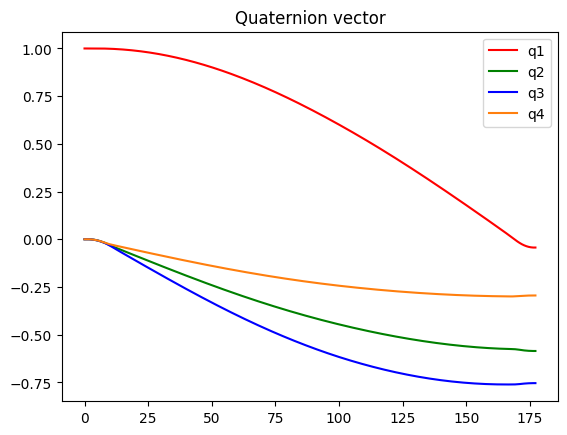

In [90]:
tsa = np.linspace(0, opti.debug.value(T), N+1)
qa = opti.debug.value(q)

%matplotlib inline
plt.title('Quaternion vector')
plt.plot(tsa, qa[0,:], 'r', label='q1')
plt.plot(tsa, qa[1,:], 'g', label='q2')
plt.plot(tsa, qa[2,:], 'b', label='q3')
plt.plot(tsa, qa[3,:], 'tab:orange', label='q4')
plt.legend()
plt.show()

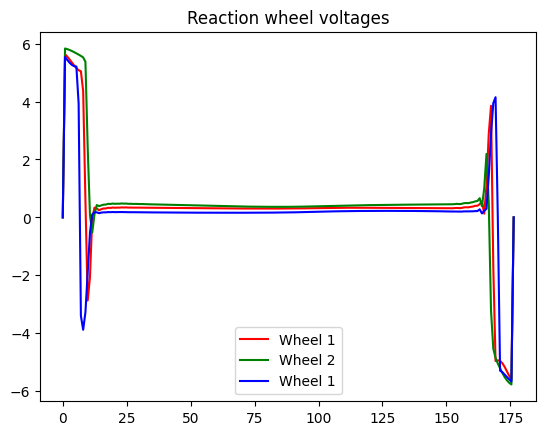

In [91]:
%matplotlib inline

Vb = opti.debug.value(U)
tsb = tsa[:-1]

plt.title("Reaction wheel voltages")
plt.plot(tsb, Vb[0,:], 'r', label="Wheel 1")
plt.plot(tsb, Vb[1,:], 'g', label="Wheel 2")
plt.plot(tsb, Vb[2,:], 'b', label="Wheel 1")
plt.legend()
plt.show()

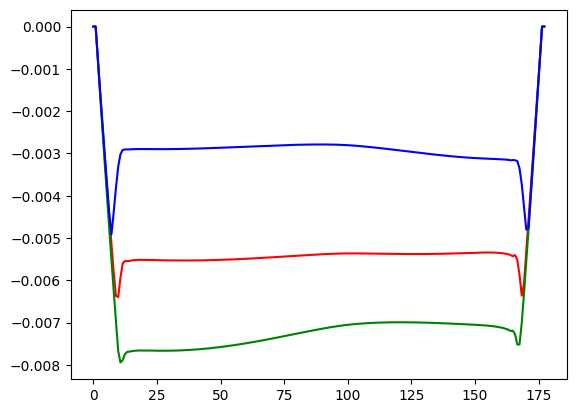

In [92]:
%matplotlib inline

wc = opti.debug.value(w)

plt.plot(tsa, wc[0,:], 'r')
plt.plot(tsa, wc[1,:], 'g')
plt.plot(tsa, wc[2,:], 'b')
plt.show()

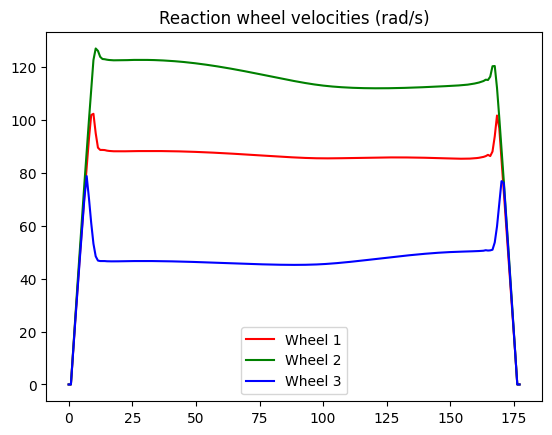

In [93]:
%matplotlib inline

Omegad = opti.debug.value(Omega)

plt.title("Reaction wheel velocities (rad/s)")
plt.plot(tsa, Omegad[0,:], 'r', label="Wheel 1")
plt.plot(tsa, Omegad[1,:], 'g', label="Wheel 2")
plt.plot(tsa, Omegad[2,:], 'b', label="Wheel 3")
plt.legend()
plt.show()

In [94]:
quat_desired = Quaternion(np.array([-0.0434363, -0.5855824, -0.7539713, -0.2945059]))

In [104]:
err = []
for i in range(0, qa.shape[1]):
    quat_cur = Quaternion(qa[:,i])
    print((quat_cur.conjugate*quat_desired).real)
#     print(np.min(np.max((quat_cur.conjugate*quat_desired).real, -1),1))
    print(np.max((quat_cur.conjugate*quat_desired).real, -1))
    print(np.min(
        np.max((quat_cur.conjugate*quat_desired).real, -1),
        1)
    )
    err.append((2*np.arccos(np.min(np.max((quat_cur.conjugate*quat_desired).real, -1),1)))*180/np.pi)

-0.043436281601197765
-0.043436281601197765


AxisError: axis 1 is out of bounds for array of dimension 0

In [ ]:
quat_cur = Quaternion(qa[:,0])


<IPython.core.display.Javascript object>


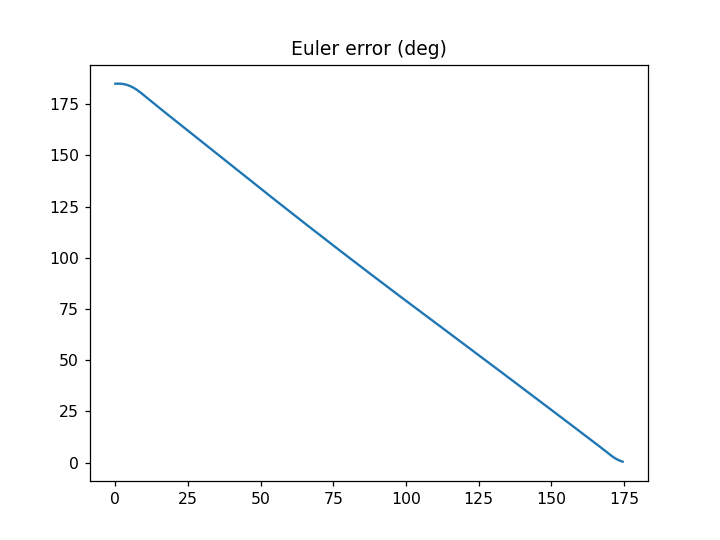

[]

In [76]:
%matplotlib notebook
plt.plot(tsa, err)
plt.title("Euler error (deg)")
plt.plot()